<a href="https://colab.research.google.com/github/AllisonOge/diabetes-classification-project/blob/main/diabetes_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥 🔥 Diabetes Classsification Machine Learning Task 🔥 🔥

We explore a nuanced version of the dataset from the [National institute of Diabetes and Digestive and Kidney Diseases](https://repository.niddk.nih.gov/search/study/). Several constraints were placed on the selection of this version from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. The dataset can be accessed through this [Kaggle link](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/download?datasetVersionNumber=1). However, the dataset has been saved in a drive and can be downloaded into the notebook when the cell is run, so there isn't a need to download the download the dataset before running the notebook. This project was taken off the freeCodeCamp [Python TensorFlow for Machine Learning – Neural Network Text Classification Tutorial](https://www.youtube.com/watch?v=VtRLrQ3Ev-U&t=3410s) course.

## Problem Statement

The goal is to develop a model to predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Accessing the dataset
The next cell has the link to the google drive repository, the id of the file and the name of the downloaded file.

In [ ]:
URL ='https://drive.google.com/u/0/uc?id=1thSxj95Tfgz6I1KOFsmXz4OHv8FcLHk4&export=download'
id = '1thSxj95Tfgz6I1KOFsmXz4OHv8FcLHk4'
filename = 'diabetes.csv'

# Download the file for Google Drive

The next cell has an utility function to download a file from google drive given the `url` and the `uid`. It uses the requests library to create a session the saves the chucks of the response from a request to the `url`. You can choose to ignore the code as it is not relevant to building the model or solving the problem statement. In some ways, it might be a bloated solution and not a necessart step. However, feel free to explore.

In [ ]:
def download_file_from_google_drive(url, uid, filename="data.csv"):
  """Creates a request object to make request to a given url
     and file id. The saves the response in a file with the 
     given filename

     Parameters
     ----------
     url : str
           the url of the resource
     uid : str
           the file id in the google drive
     filename : str, optional
                the name of the output file (default is `data.csv`)
     
     Returns
     -------
      None
  """
  def get_confirm_token(response):
    """Gets the access token if any
       
       Parameters
       ----------
       response object : any
                         response object of a get request
        Returns
        -------
        str | None

    """
    for key, value in response.cookies.items():
      if key.startswith('download_warning'):
        return value

    return None

  def save_response_content(response):
    """Save the response to the output file
       
       Parameters
       ----------
       response : any
                  response obect of a get request

       Returns
       -------
       None
    
    """
    CHUNK_SIZE = 32768

    with open(filename, 'wb') as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk:
          f.write(chunk)


  session = requests.Session()

  response = session.get(url, params = {'id': id}, stream = True)
  token = get_confirm_token(response)

  if token:
    params = {'id': id, 'confirm': token }
    response = session.get(URL, params = params, stream = True)

  save_response_content(response)

In [ ]:
download_file_from_google_drive(URL, id, filename)

# Exploratory Data Analysis

![EDA steps](https://datos.gob.es/sites/default/files/u322/grafico.jpg)
The exploratory data analysis (EDA) is taking the necessary step to understand the data. It consist of applying a set of statistical techniques aimed at exploring, describing and summarizing the nature of the data. This way we can identify possible error, reveal the presence of outliers, check the relationship between variables (correlations) and their possible redundancy, and perform a descriptive analysis of the data by means of grapical representations and summaries of the most significant aspects.

In [ ]:
diabetes_df = pd.read_csv(filename)

In [ ]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# view datatypes of each column
diabetes_df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
# check for nulls in dataframe
diabetes_df.isnull().values.any()

False

## 🥽 Data Visualization

After our numerical exploration of the data for NaNs and missing values (termed as the data cleaning step), we proceed to the visualization step. This is an indepth topic and can only be summarized in this notebook. The choice of visualization is based on the question one is trying to answer. In this step, we turn to histograms to give a visual of the relationship between the columns of the dataset and the output we want to predict (the `Outcome`).

So we will make a histogram of each column except the `Outcome` column to visualize the distribution of the two cases `Diabetes` or `No Diabetes`. The `Diabetic` case is coloured blue while the `No Diabetes` case is coloured red. Choosing a bin size of the square root of the number of data point is a good rule of thumb.

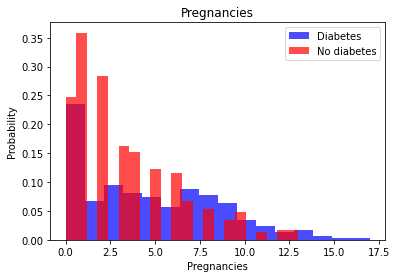

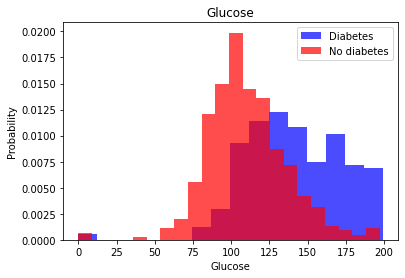

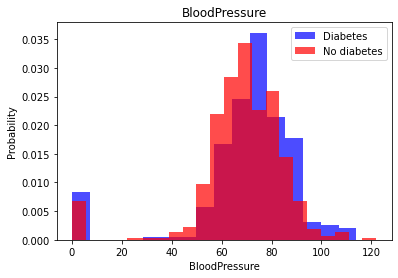

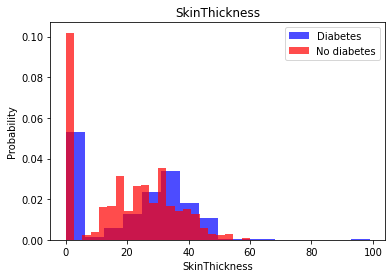

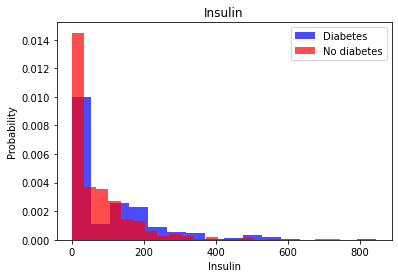

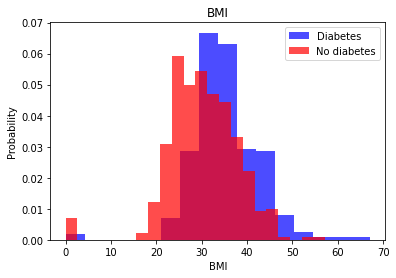

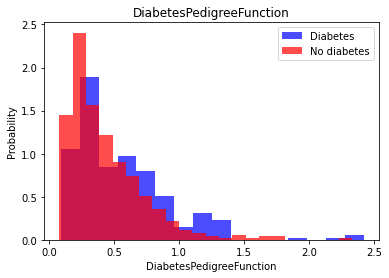

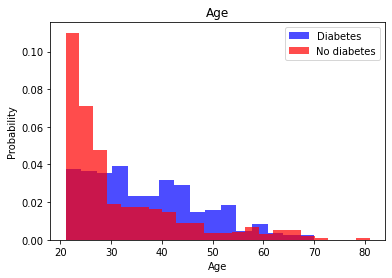

In [ ]:
for i in range(len(diabetes_df.columns[:-1])):
  label = diabetes_df.columns[i]
  diabetes_data = diabetes_df[diabetes_df['Outcome']==1][label]
  n_bins = np.sqrt(len(diabetes_data))
  plt.hist(diabetes_data, color='blue', label='Diabetes', alpha=0.7, density=True, bins=int(n_bins))
  no_diabetes_data = diabetes_df[diabetes_df['Outcome']==0][label]
  n_bins = np.sqrt(len(no_diabetes_data))
  plt.hist(no_diabetes_data, color='red', label='No diabetes', alpha=0.7, density=True, bins=int(n_bins))
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()

# 👩‍🍳 Prepare the dataset

The dataset will be splitted into test, train, and validation **sets**

In [ ]:
# split the features and labels of the data
X = diabetes_df[diabetes_df.columns[:-1]].values
y = diabetes_df[diabetes_df.columns[-1]].values

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
batch_size = 16
train_dataset = tf.data.Dataset\
                .from_tensor_slices((X_train, y_train))\
                .shuffle(buffer_size=1024)\
                .batch(batch_size=batch_size)

In [ ]:
val_dataset = tf.data.Dataset\
              .from_tensor_slices((X_test, y_test))\
              .shuffle(buffer_size=1024)\
              .batch(batch_size=batch_size)

# 🧠 Building the model and training loop

Next, we build the models using the keras library. Our neural network will have two hidden layers of 16 nodes each, a single node output layer and an input layer of N number of nodes; where N is the number of features in the dataset.

In [ ]:
def build_model(input_shape):
  return tf.keras.Sequential([
                             tf.keras.layers.Dense(16, input_shape=(input_shape,), activation='relu'), 
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                              ])

## 🚆 ➰ Writing a custom train and evaluation function

Keras already has methods to build and train a model. This is particularly heplful to speed the development process. Shown below is the sequence of steps taken to build and train a model in keras.
```python
  # build the model
  model = build_model(X.shape[1])
  # compile the models for training with 
  # training alogirithm, loss funciton 
  # and measurement metric
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])
  # train the model and validate training
  # alongside training with test dataset
  model.fit(X_train, y_train, batch_size=batch_size, epochs=20,
            validation_data=(X_valid, y_valid))
  # test model on a validation
  # dataset to measure the accuracy
  # of the model 
  model.evaluate(X_valid, y_valid)
```

However, we will custom define this training and evaluation steps to give us more granuality with our development.

In [ ]:
def train(train_dataset, 
          val_dataset, model, 
          loss_fn, optimizer, 
          epochs, train_acc_metric, 
          val_acc_metric):
  """
      A custom training and evaluation funtion for an NN model with Keras and TF

      Parameters
      ---------
      train_dataset : (tf.tensor)
                      a tensor of  
  
  """
  train_loss = []
  val_loss = []

  for epoch in range(epochs):
    print("\nStart of epoch %d" % epoch)

    # iterate over a batch of the training dataset
    for step, (X_train_batch, y_train_batch) in enumerate(train_dataset): 
      # Create a scope with tf.GradientTape() 
      # to record the operation run during
      # forward pass to enable auto-differentiation
      with tf.GradientTape() as tape:
        # Through the forward propagation
        # of the network, the operations 
        # run at the layers are recorded
        # on GradientTape()
        logits = model(X_train_batch, training=True)

        # Then we compute the loss value for
        # the batch
        loss = loss_fn(y_train_batch, logits)

      # Retrieve the gradients of the trainable weights 
      gradients = tape.gradient(loss, model.trainable_weights)

      # update the weights using an
      # optimizer instance
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))

      # save the loss
      train_loss.append(float(loss))

      # save the accuracy of the training ops
      train_acc_metric.update_state(y_train_batch, logits)

      # Show progess at every 10 iterations
      if step % 10 == 0:
        print("Training loss (for a batch) at step %d: %.4f" % (step + 1, loss))
        print("So far, %d samples have been used to train the model" % ((step + 1) * batch_size))

    # evaluate the trained model
    # iterate over batches of the validation dataset
    for step, (X_val_batch, y_val_batch) in enumerate(val_dataset):
      # forward propagate through the network
      logits = model(X_val_batch, training=False)

      # compute the loss
      val_loss.append(float(loss_fn(y_val_batch, logits)))

      # save the accuracy of the validation ops
      val_acc_metric.update_state(y_val_batch, logits)

    
    # Display the accuracy of the training ops
    train_acc = train_acc_metric.result()
    print("The accuracy of the training is %.3f" % float(train_acc))

    # Display the accuracy of the validation ops
    val_acc = val_acc_metric.result()
    print("The accuracy of the validation is %.3f" % float(val_acc))

    # Reset the metric for the next epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

    # ⭐: log metrics using wandb.log
    wandb.log({'epochs': epoch,
                'loss': np.mean(train_loss),
                'acc': float(train_acc), 
                'val_loss': np.mean(val_loss),
                'val_acc':float(val_acc)})
    

In [ ]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.001,
              "epochs": 20,
              "batch_size": batch_size,
              "log_step": 2,
              "val_log_step": 1
           }

run = wandb.init(project="diabetes-classification-project", config=config)
config = wandb.config

# build the model
model = build_model(X.shape[1])

# initialize the optimizer, loss function, accuracy metrics

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

loss_fn = tf.keras.losses.BinaryCrossentropy()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

# train and evaluate the model
train(train_dataset, 
      val_dataset, 
      model, loss_fn, 
      optimizer, 
      config.epochs, 
      train_acc_metric, 
      val_acc_metric)

# indicate the end of a run
run.finish() 


Start of epoch 0
Training loss (for a batch) at step 1: 4.1343
So far, 16 samples have been used to train the model
Training loss (for a batch) at step 11: 4.0209
So far, 176 samples have been used to train the model
Training loss (for a batch) at step 21: 2.4440
So far, 336 samples have been used to train the model
The accuracy of the training is 0.357
The accuracy of the validation is 0.317

Start of epoch 1
Training loss (for a batch) at step 1: 1.7566
So far, 16 samples have been used to train the model
Training loss (for a batch) at step 11: 0.9212
So far, 176 samples have been used to train the model
Training loss (for a batch) at step 21: 2.1527
So far, 336 samples have been used to train the model
The accuracy of the training is 0.359
The accuracy of the validation is 0.314

Start of epoch 2
Training loss (for a batch) at step 1: 1.4631
So far, 16 samples have been used to train the model
Training loss (for a batch) at step 11: 1.3584
So far, 176 samples have been used to trai

acc,▁▅▁▇█▂▂▅▄▄▂▄▅▂▂▅▇▅▄█
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▅▃▆▁▆▅█▆▆█▅▃▆▅▁█▅▅▅▅
val_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
acc,0.36063
epochs,19
loss,1.00091
val_acc,0.3175
val_loss,0.93268


## Scaling the features

This is a preprocessing step in machine learning, but why? I have seen two reasons to preform feature scaling on your dataset before training your model. 

- To smoothen gradient descent
- To allow spatial dependent ML taks like SVM, K-means, K-NN, neural network or deep learning interpret all features on the same scale. This ensures that a feature with relatively higher magnitude will not govern or control the trained model.

In this project, we will observe the effect of scaled and unscaled dataset on the accuracy of the model.

In scikit-learn, there are three scalers, `MinMaxScaler`, `StandardScaler` and `RobustScaler`. `MinMaxScaler` shifts the values of the features to be bounded between 0 and 1. `StandardScaler` rescales the values of the features so that they demonstrate the properties of a standard gaussian distribution. `RobustScaler` applies standard scaling plus the robustness to outliers. Hence, it removes the median and scales the data according to the interquartile range.

See a comparison of the three scalers on a [Boston toy dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) shown as a box plot below.
![MinMaxScalervsStandardScalervsRobustScaler](https://miro.medium.com/max/720/1*L2HSvzY5tSoEEyksocOpaA.png)

> Credit to [Jason Chong](https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048)





In [ ]:
# instantiate the StandardScaler class from scikit-learn
scaler = StandardScaler()
X = scaler.fit_transform(X)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=diabetes_df.columns)

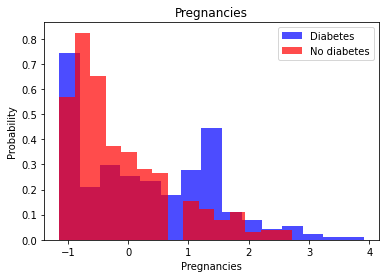

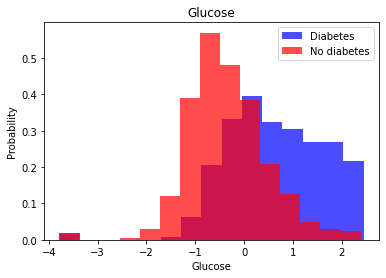

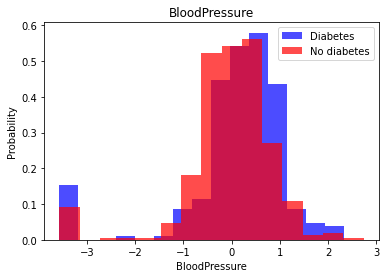

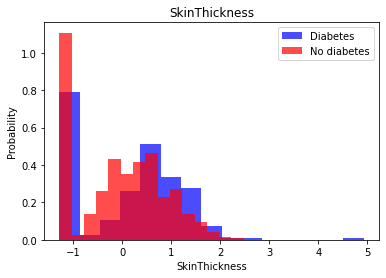

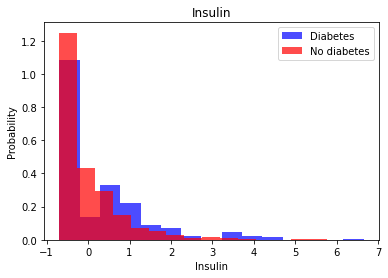

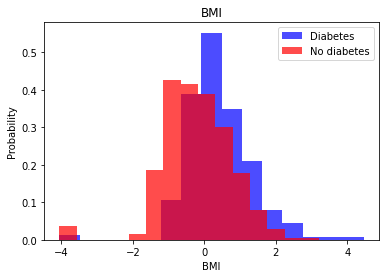

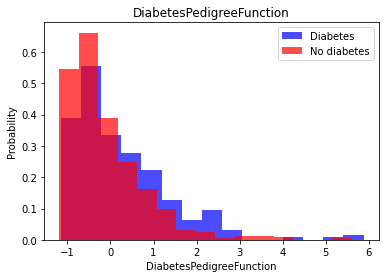

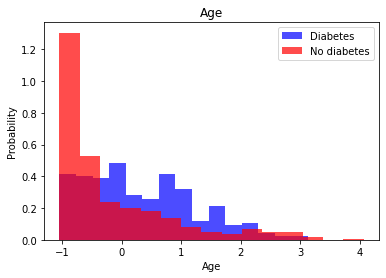

In [ ]:
for i in range(len(diabetes_df.columns[:-1])):
  label = transformed_df.columns[i]
  plt.hist(transformed_df[transformed_df['Outcome']==1][label], color='blue', label='Diabetes', alpha=0.7, density=True, bins=15)
  plt.hist(transformed_df[transformed_df['Outcome']==0][label], color='red', label='No diabetes', alpha=0.7, density=True, bins=15)
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [ ]:
over = RandomOverSampler()
X, y = over.fit_resample(X, y)
data = np.hstack((X, np.reshape(y, (-1, 1))))
transformed_df = pd.DataFrame(data, columns=diabetes_df.columns)

In [ ]:
(len(transformed_df[transformed_df['Outcome']==1]), len(transformed_df[transformed_df['Outcome']==0]))

(500, 500)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
model = build_model(X.shape[1])

In [ ]:
model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
38/38 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5533 - val_loss: 0.6856 - val_accuracy: 0.5750
Epoch 2/20
38/38 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6733 - val_loss: 0.6373 - val_accuracy: 0.6450
Epoch 3/20
38/38 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.7283 - val_loss: 0.5900 - val_accuracy: 0.7100
Epoch 4/20
38/38 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7417 - val_loss: 0.5515 - val_accuracy: 0.7050
Epoch 5/20
38/38 [==============================] - 0s 3ms/step - loss: 0.5492 - accuracy: 0.7433 - val_loss: 0.5195 - val_accuracy: 0.7200
Epoch 6/20
38/38 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7467 - val_loss: 0.4929 - val_accuracy: 0.7500
Epoch 7/20
38/38 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.7450 - val_loss: 0.4743 - val_accuracy: 0.7550
Epoch 8/20
38/38 [==

In [ ]:
model.evaluate(X_train, y_train)

19/19 [==============================] - 0s 2ms/step - loss: 0.7154 - accuracy: 0.4817


[0.7153578400611877, 0.4816666543483734]

In [ ]:
model.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 2ms/step - loss: 0.7470 - accuracy: 0.4700


[0.7470095157623291, 0.4699999988079071]